## Import libraries

In [846]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    RBF,
    ConstantKernel as C,
    ExpSineSquared,
    DotProduct,
    WhiteKernel
)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_percentage_error

## Read in data

In [847]:
# Read data
train = pd.read_csv('./processed_data/train.csv')
train['tpep_pickup_datetime'] = pd.to_datetime(train['tpep_pickup_datetime'])

# Grab hour interval
train['hour'] = train['tpep_pickup_datetime'].dt.hour
train = train.set_index('tpep_pickup_datetime')

# Add simple index after setting time index
train['time_index'] = range(1, len(train) + 1)

train.head()

,passenger_count,trip_distance,DOLocationID,fare_amount,total_amount,tip_amount,pickup_count,is_holiday,pickup_time,weekend,weekday,hour,time_index
tpep_pickup_datetime,,,,,,,,,,,,,
2022-01-24 00:00:00,58.0,186.68,6696,674.43,977.74,1.960,53,0,2022-01-24 00:00:00,False,0,0,1
2022-01-24 03:00:00,77.0,117.75,9576,525.20,860.47,1.805,62,0,2022-01-24 03:00:00,False,0,3,2
2022-01-24 06:00:00,726.0,1012.97,97325,5133.50,8148.27,1.950,600,0,2022-01-24 06:00:00,False,0,6,3
2022-01-24 09:00:00,534.0,802.18,68018,4512.80,6732.37,2.000,419,0,2022-01-24 09:00:00,False,0,9,4
2022-01-24 12:00:00,466.0,875.02,56398,4159.80,6085.32,1.980,360,0,2022-01-24 12:00:00,False,0,12,5


In [848]:
# Read data
test = pd.read_csv('./processed_data/test.csv')
test['tpep_pickup_datetime'] = pd.to_datetime(test['tpep_pickup_datetime'])

# Grab hour interval
test['hour'] = test['tpep_pickup_datetime'].dt.hour
test = test.set_index('tpep_pickup_datetime')

# Add simple index after setting time index
test['time_index'] = range(1, len(test) + 1)
test.head()

,passenger_count,trip_distance,DOLocationID,fare_amount,total_amount,tip_amount,pickup_count,is_holiday,pickup_time,weekend,weekday,hour,time_index
tpep_pickup_datetime,,,,,,,,,,,,,
2024-01-22 00:00:00,65.0,122.21,8152,651.10,998.27,1.000,57,0,2024-01-22 00:00:00,False,0,0,1
2024-01-22 03:00:00,72.0,146.79,11424,824.51,1374.38,2.300,73,0,2024-01-22 03:00:00,False,0,3,2
2024-01-22 06:00:00,563.0,895.70,83620,6453.92,9720.19,2.520,498,0,2024-01-22 06:00:00,False,0,6,3
2024-01-22 09:00:00,718.0,1009.50,95036,8698.33,12604.08,2.940,556,0,2024-01-22 09:00:00,False,0,9,4
2024-01-22 12:00:00,571.0,997.24,78255,7118.09,10389.52,2.945,468,0,2024-01-22 12:00:00,False,0,12,5


In [849]:
# See data charactertistcs
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1808 entries, 2022-01-24 00:00:00 to 2023-05-15 21:00:00
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   passenger_count  1808 non-null   float64
 1   trip_distance    1808 non-null   float64
 2   DOLocationID     1808 non-null   int64  
 3   fare_amount      1808 non-null   float64
 4   total_amount     1808 non-null   float64
 5   tip_amount       1808 non-null   float64
 6   pickup_count     1808 non-null   int64  
 7   is_holiday       1808 non-null   int64  
 8   pickup_time      1808 non-null   object 
 9   weekend          1808 non-null   bool   
 10  weekday          1808 non-null   int64  
 11  hour             1808 non-null   int32  
 12  time_index       1808 non-null   int64  
dtypes: bool(1), float64(5), int32(1), int64(5), object(1)
memory usage: 178.3+ KB


In [850]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 904 entries, 2024-01-22 00:00:00 to 2024-05-13 21:00:00
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   passenger_count  904 non-null    float64
 1   trip_distance    904 non-null    float64
 2   DOLocationID     904 non-null    int64  
 3   fare_amount      904 non-null    float64
 4   total_amount     904 non-null    float64
 5   tip_amount       904 non-null    float64
 6   pickup_count     904 non-null    int64  
 7   is_holiday       904 non-null    int64  
 8   pickup_time      904 non-null    object 
 9   weekend          904 non-null    bool   
 10  weekday          904 non-null    int64  
 11  hour             904 non-null    int32  
 12  time_index       904 non-null    int64  
dtypes: bool(1), float64(5), int32(1), int64(5), object(1)
memory usage: 89.2+ KB


In [851]:
## SHRINK SIZES IF NECESSARY
#train = train[:1000]
#test = test[:1000]

## EDA

In [853]:
train.groupby('hour')['pickup_count'].mean()

hour
0     154.358407
3      78.561947
6     514.977876
9     602.650442
12    589.654867
15    606.044248
18    632.977876
21    448.022124
Name: pickup_count, dtype: float64

In [856]:
test.groupby('hour')['pickup_count'].mean()

hour
0     173.238938
3      73.778761
6     438.840708
9     612.672566
12    599.477876
15    595.539823
18    608.309735
21    530.000000
Name: pickup_count, dtype: float64

## Plot general Time Series

## Over chosen time interval

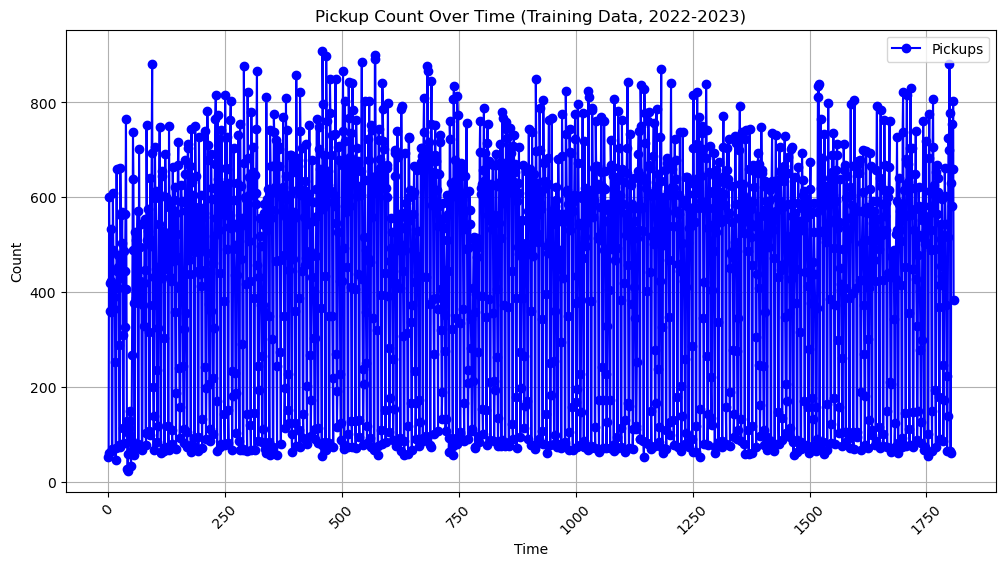

In [858]:
plt.figure(figsize=(12, 6))
plt.plot(train['time_index'], train['pickup_count'], marker='o', label='Pickups', color='blue')
plt.title('Pickup Count Over Time (Training Data, 2022-2023)')
plt.xlabel('Time')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

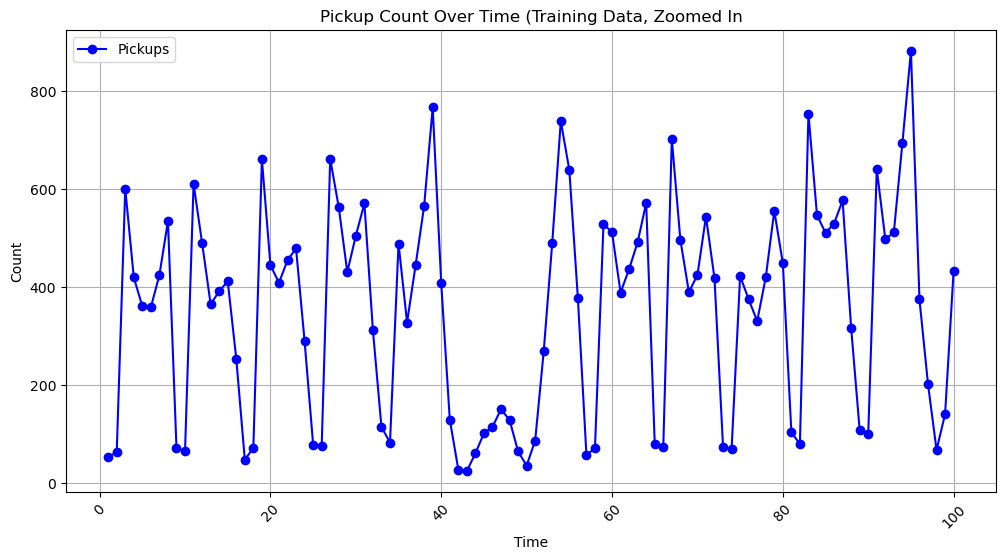

In [859]:
plt.figure(figsize=(12, 6))
plt.plot(train['time_index'][:100], train['pickup_count'][:100], marker='o', label='Pickups', color='blue')
plt.title('Pickup Count Over Time (Training Data, Zoomed In First 100)')
plt.xlabel('Time')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

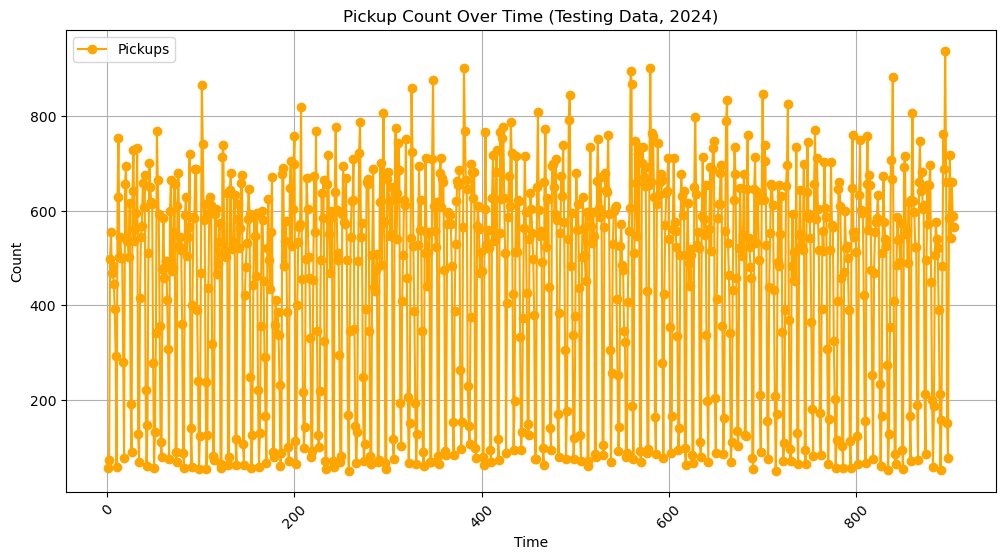

In [860]:
plt.figure(figsize=(12, 6))
plt.plot(test['time_index'], test['pickup_count'], marker='o', label='Pickups', color='orange')
plt.title('Pickup Count Over Time (Testing Data, 2024)')
plt.xlabel('Time')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

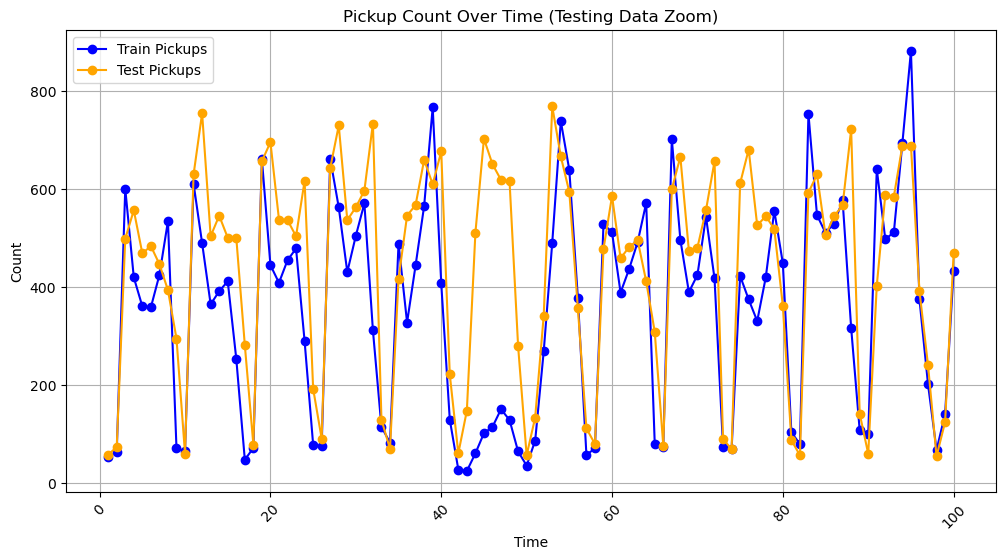

In [861]:
plt.figure(figsize=(12, 6))
plt.plot(train['time_index'][:100], train['pickup_count'][:100], marker='o', label='Train Pickups', color='blue')
plt.plot(test['time_index'][:100], test['pickup_count'][:100], marker='o', label='Test Pickups', color='orange')
plt.title('Pickup Count Over Time (First 100)')
plt.xlabel('Time')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

## Over the hour

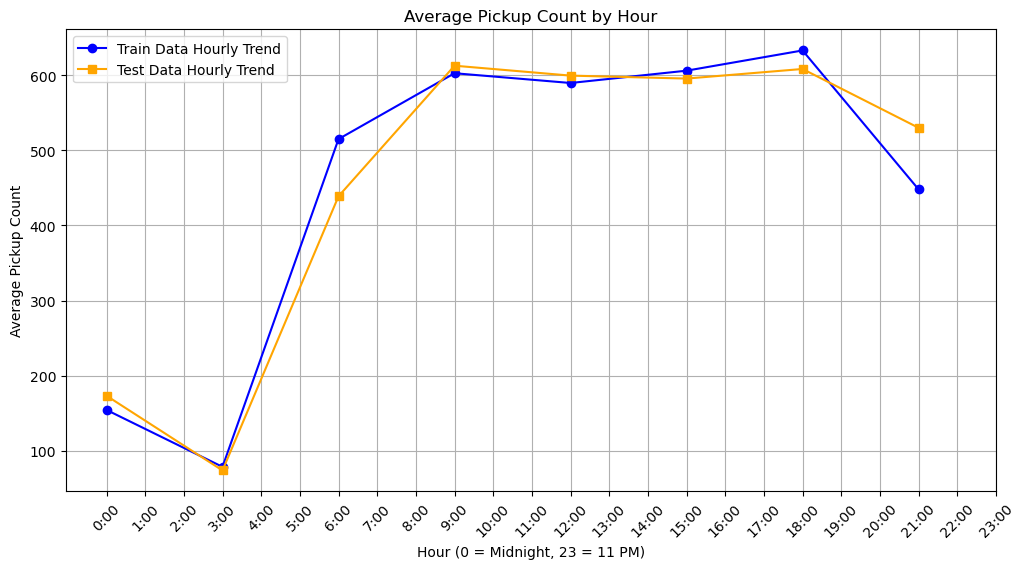

In [862]:
# Group by hour and calculate the mean pickup count for each hour
hourly_trend_train = train.groupby('hour')['pickup_count'].mean()
hourly_trend_test = test.groupby('hour')['pickup_count'].mean()

# Plot hourly trend
plt.figure(figsize=(12, 6))
plt.plot(
    hourly_trend_train.index,
    hourly_trend_train.values,
    marker='o',
    label='Train Data Hourly Trend',
    color='blue'
)
plt.plot(
    hourly_trend_test.index,
    hourly_trend_test.values,
    marker='s',
    label='Test Data Hourly Trend',
    color='orange'
)
plt.title('Average Pickup Count by Hour')
plt.xlabel('Hour (0 = Midnight, 23 = 11 PM)')
plt.ylabel('Average Pickup Count')
plt.xticks(
    ticks=range(0, 24),
    labels=[f'{h}:00' for h in range(0, 24)],  # Formats hour labels as '0:00', '1:00', etc.
    rotation=45
)
plt.grid()
plt.legend()
plt.show()

## Over each weekday

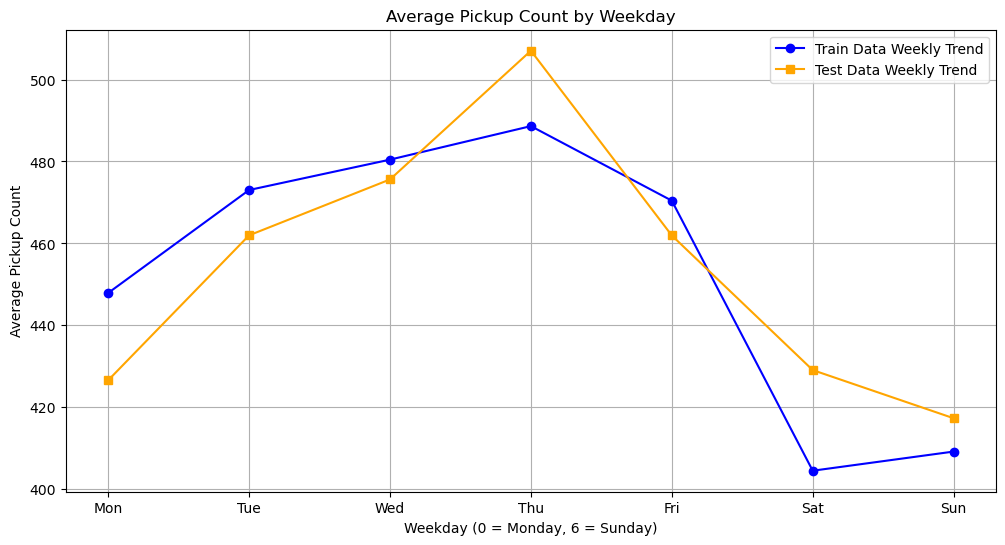

In [863]:
# Group by weekday and calculate the mean pickup count for each weekday
weekly_trend_train = train.groupby('weekday')['pickup_count'].mean()
weekly_trend_test = test.groupby('weekday')['pickup_count'].mean()

# Plot weekly trend
plt.figure(figsize=(12, 6))
plt.plot(
    weekly_trend_train.index,
    weekly_trend_train.values,
    marker='o',
    label='Train Data Weekly Trend',
    color='blue'
)
plt.plot(
    weekly_trend_test.index,
    weekly_trend_test.values,
    marker='s',
    label='Test Data Weekly Trend',
    color='orange'
)
plt.title('Average Pickup Count by Weekday')
plt.xlabel('Weekday (0 = Monday, 6 = Sunday)')
plt.ylabel('Average Pickup Count')
plt.xticks(
    ticks=weekly_trend_train.index,
    labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
)
plt.grid()
plt.legend()
plt.show()


## Over the weeks

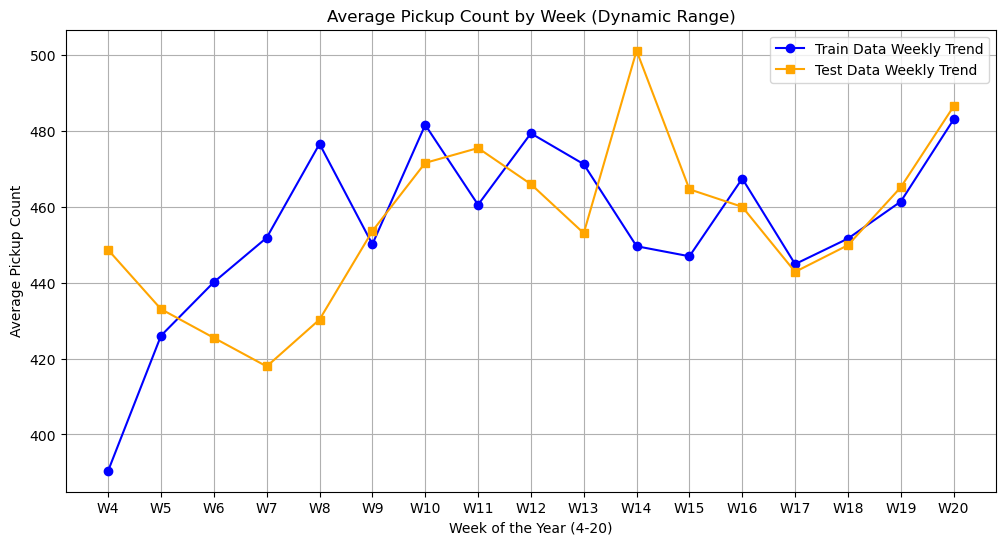

In [864]:
# Group by week of the year and calculate the mean pickup count for each week
train['pickup_time'] = pd.to_datetime(train['pickup_time'])
test['pickup_time'] = pd.to_datetime(test['pickup_time'])
train['week'] = train['pickup_time'].dt.isocalendar().week
test['week'] = test['pickup_time'].dt.isocalendar().week

# Determine the min and max week from both datasets
min_week = min(train['week'].min(), test['week'].min())
max_week = max(train['week'].max(), test['week'].max())

# Group by week for the range of weeks in the data
weekly_trend_train = train.groupby('week')['pickup_count'].mean()
weekly_trend_test = test.groupby('week')['pickup_count'].mean()

# Plot weekly trend
plt.figure(figsize=(12, 6))
plt.plot(
    weekly_trend_train.index,
    weekly_trend_train.values,
    marker='o',
    label='Train Data Weekly Trend',
    color='blue'
)
plt.plot(
    weekly_trend_test.index,
    weekly_trend_test.values,
    marker='s',
    label='Test Data Weekly Trend',
    color='orange'
)
plt.title('Average Pickup Count by Week (Dynamic Range)')
plt.xlabel(f'Week of the Year ({min_week}-{max_week})')
plt.ylabel('Average Pickup Count')
plt.xticks(
    ticks=range(min_week, max_week + 1, max(1, (max_week - min_week) // 10)),  # Adjust ticks dynamically
    labels=[f'W{k}' for k in range(min_week, max_week + 1, max(1, (max_week - min_week) // 10))]
)
plt.grid()
plt.legend()
plt.show()


## Over the month

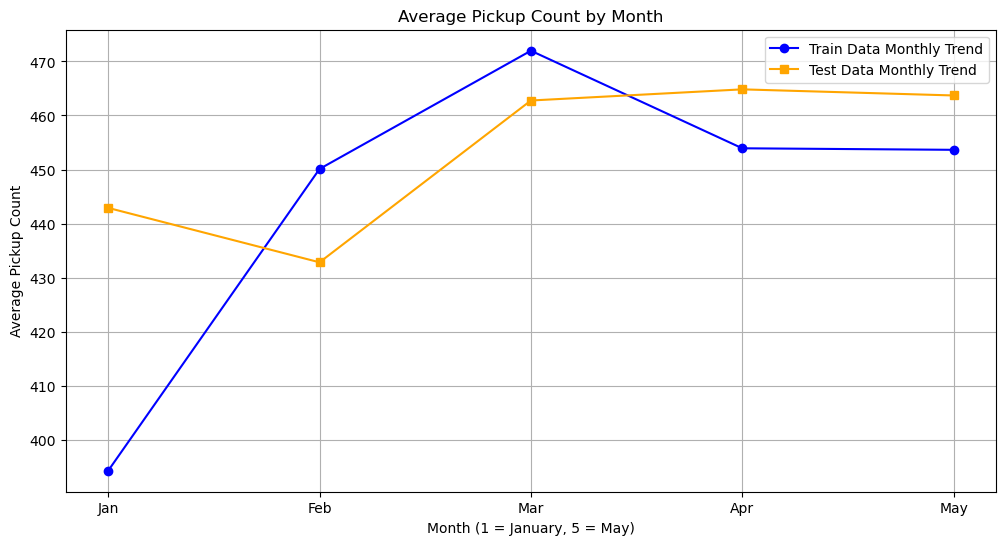

In [865]:
# Group by month and calculate the mean pickup count for each month
monthly_trend_train = train.groupby(train['pickup_time'].dt.month)['pickup_count'].mean()
monthly_trend_test = test.groupby(test['pickup_time'].dt.month)['pickup_count'].mean()

# Plot monthly trend
plt.figure(figsize=(12, 6))
plt.plot(
    monthly_trend_train.index,
    monthly_trend_train.values,
    marker='o',
    label='Train Data Monthly Trend',
    color='blue'
)
plt.plot(
    monthly_trend_test.index,
    monthly_trend_test.values,
    marker='s',
    label='Test Data Monthly Trend',
    color='orange'
)
plt.title('Average Pickup Count by Month')
plt.xlabel('Month (1 = January, 5 = May)')
plt.ylabel('Average Pickup Count')
plt.xticks(
    ticks=range(1, 6),
    labels=[
        'Jan', 'Feb', 'Mar', 'Apr', 'May'
    ]
)
plt.grid()
plt.legend()
plt.show()


## Model Fitting

## All vars

In [ ]:
# Features (X) - Including the new feature
X_train = train[['hour', 'weekday', 'weekend']].values
X_test = test[['hour', 'weekday', 'weekend']].values

# Features (X) - All columns except 'pickup_count'
#X_train = train[['hour']].values
#X_test = test[['hour']].values

# Target (y) - 'pickup_count'
# Subtract the mean function (use training data)
mean_func = train['pickup_count'].mean()
y_train = train['pickup_count'].values
y_test = test['pickup_count'].values

# Scale features if necessary (important for GP models to avoid dominance of larger scale features)
## HERE
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

#print(X_scaled)

In [867]:
X_train

array([[0.        , 0.        , 0.        ],
       [0.14285714, 0.        , 0.        ],
       [0.28571429, 0.        , 0.        ],
       ...,
       [0.71428571, 0.        , 0.        ],
       [0.85714286, 0.        , 0.        ],
       [1.        , 0.        , 0.        ]])

In [868]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1808, 3), (1808,), (904, 3), (904,))

In [869]:
# Define the GP kernel
# - RBF for smooth trends
# - ExpSineSquared for periodicity
kernel = (
   C(30.0, (1e-1, 1e5))  # Constant term to scale the entire kernel
   * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))  # Squared exponential

    + C(50.0, (1e-1, 1e5))  # Constant term for cosine scaling
    * ExpSineSquared(length_scale=1.0, periodicity=8, periodicity_bounds=(1e-2, 1e2), length_scale_bounds=(1e-2, 1e2))  # Cosine
## These two above work

    + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-5, 1e5))
)

# Instantiate and fit the Gaussian Process Regressor
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=50, alpha=1e-5)
gp.fit(X_train, y_train)
print("Fit Complete")
print("Learned Kernel:", gp.kernel_)

# Make predictions (add mean back)
y_pred, sigma = gp.predict(X_test, return_std=True)

Fit Complete
Learned Kernel: 212**2 * RBF(length_scale=0.157) + 316**2 * ExpSineSquared(length_scale=87.1, periodicity=0.518) + WhiteKernel(noise_level=5.9e+03)


/Users/willcalandra/anaconda3/envs/tsa/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Root Mean Squared Error: 88.760
R^2 Score: 0.854


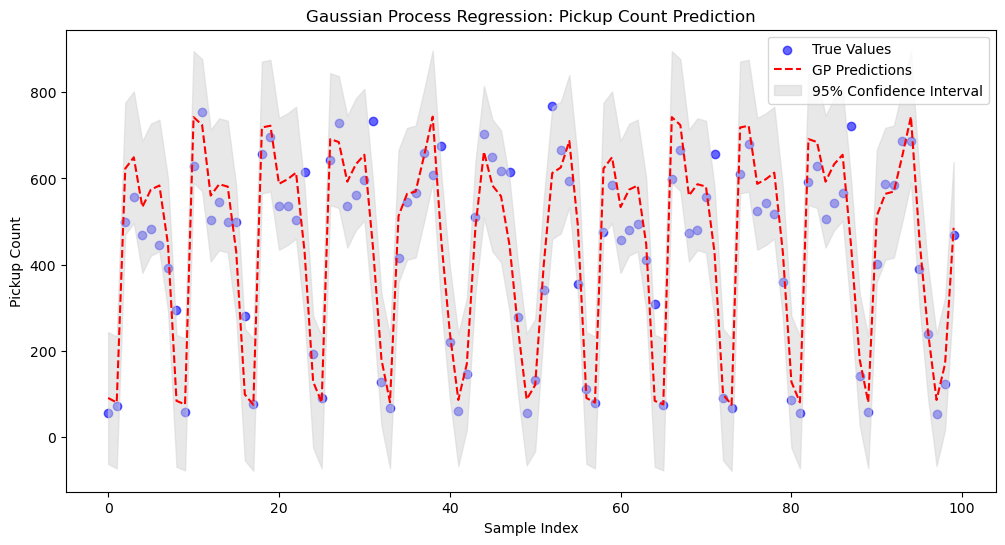

In [870]:
rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Root Mean Squared Error: {rmse:.3f}")
print(f"MAPE: {mape:.3f}")

# Visualize predictions
plt.figure(figsize=(12, 6))
plt.scatter(range(len(y_test[:100])), y_test[:100], label="True Values", color="blue", alpha=0.6)
plt.plot(range(len(y_pred[:100])), y_pred[:100], label="GP Predictions", color="red", linestyle="dashed")
plt.fill_between(
    range(len(y_pred[:100])),
    y_pred[:100] - 1.96 * sigma[:100],
    y_pred[:100] + 1.96 * sigma[:100],
    color="lightgrey",
    alpha=0.5,
    label="95% Confidence Interval",
)
plt.xlabel("Sample Index")
plt.ylabel("Pickup Count")
plt.title("Gaussian Process Regression: Pickup Count Prediction (First 100)")
plt.legend()
plt.show()

In [871]:
sigma.mean()

np.float64(152.80763444527642)

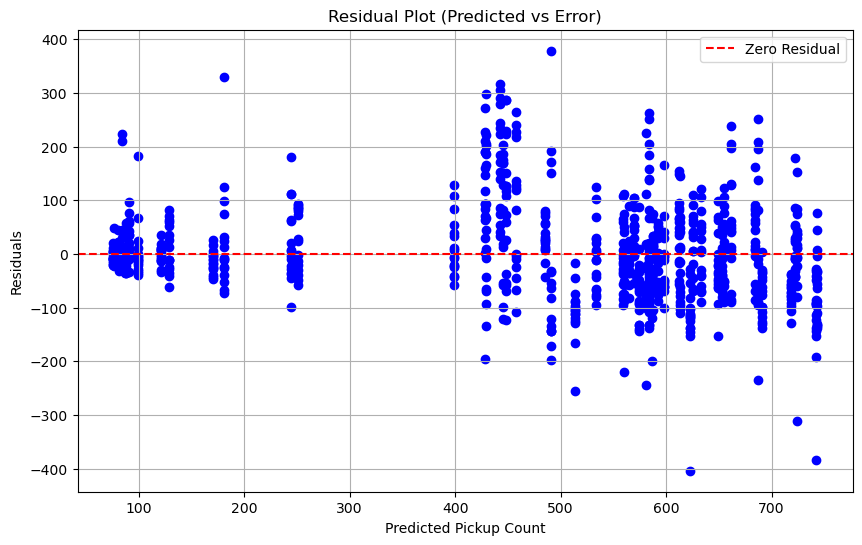

In [873]:
# Compute residuals
residuals = y_test - y_pred

# Residual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue')
plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
plt.xlabel('Predicted Pickup Count')
plt.ylabel('Residuals')
plt.title('Residual Plot (Predicted vs Error)')
plt.legend()
plt.grid(True)
plt.show()


Training with kernel: RBF + ExpSineSquared + WhiteKernel


/Users/willcalandra/anaconda3/envs/tsa/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/willcalandra/anaconda3/envs/tsa/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/willcalandra/anaconda3/envs/tsa/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__periodicity is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  

Fit Complete
Learned Kernel: 212**2 * RBF(length_scale=0.157) + 316**2 * ExpSineSquared(length_scale=100, periodicity=100) + WhiteKernel(noise_level=5.9e+03)
Kernel: RBF + ExpSineSquared + WhiteKernel
Root Mean Squared Error: 88.760
R^2 Score: 0.854
MAPE: 16.169%


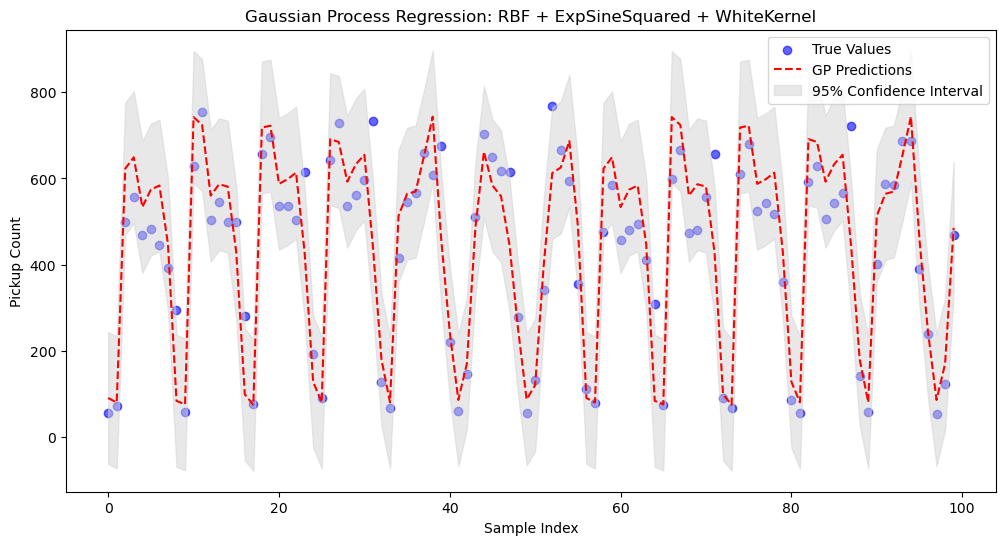

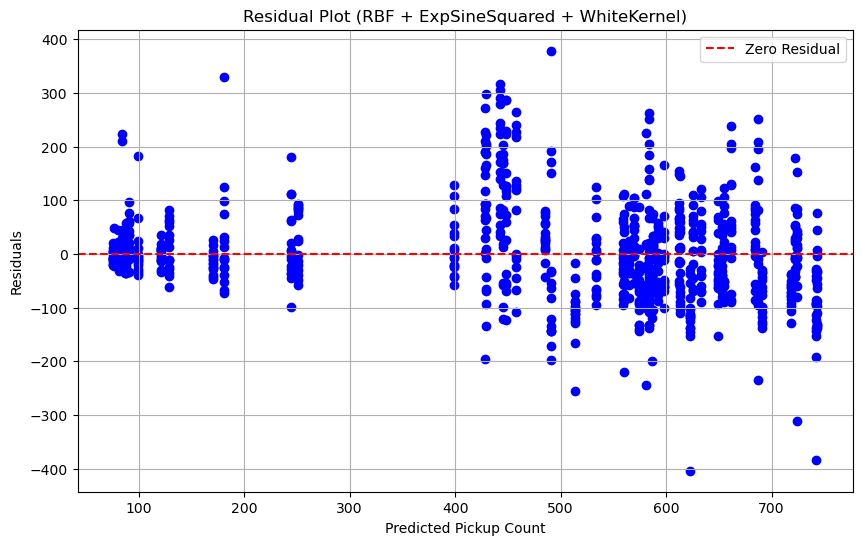

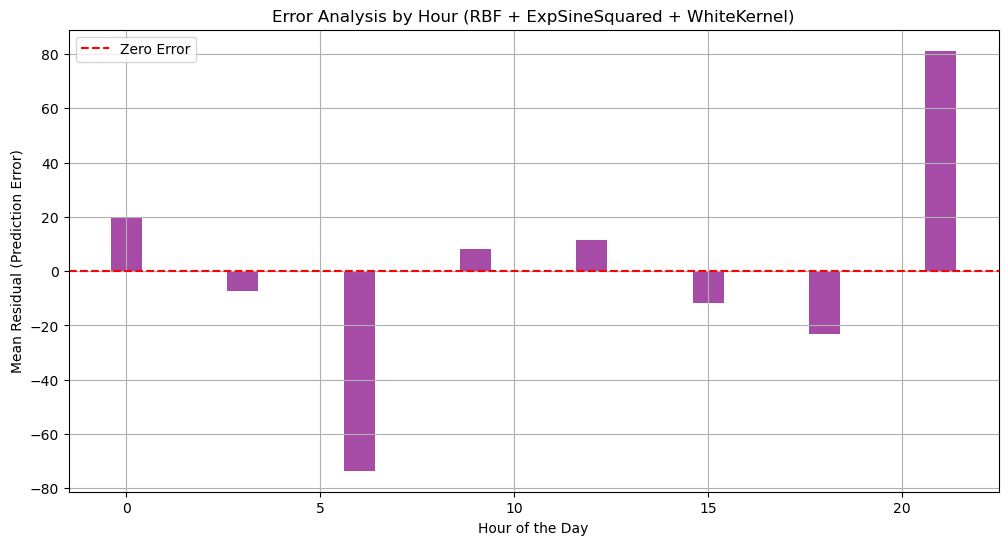

Training with kernel: RBF + WhiteKernel
Fit Complete
Learned Kernel: 316**2 * RBF(length_scale=0.18) + WhiteKernel(noise_level=5.9e+03)
Kernel: RBF + WhiteKernel
Root Mean Squared Error: 88.783
R^2 Score: 0.854
MAPE: 16.156%


/Users/willcalandra/anaconda3/envs/tsa/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


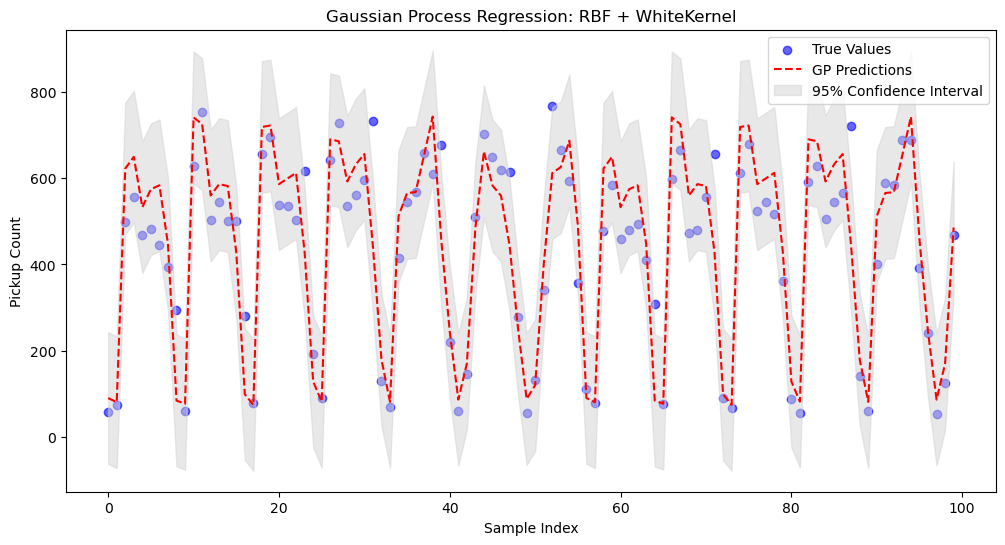

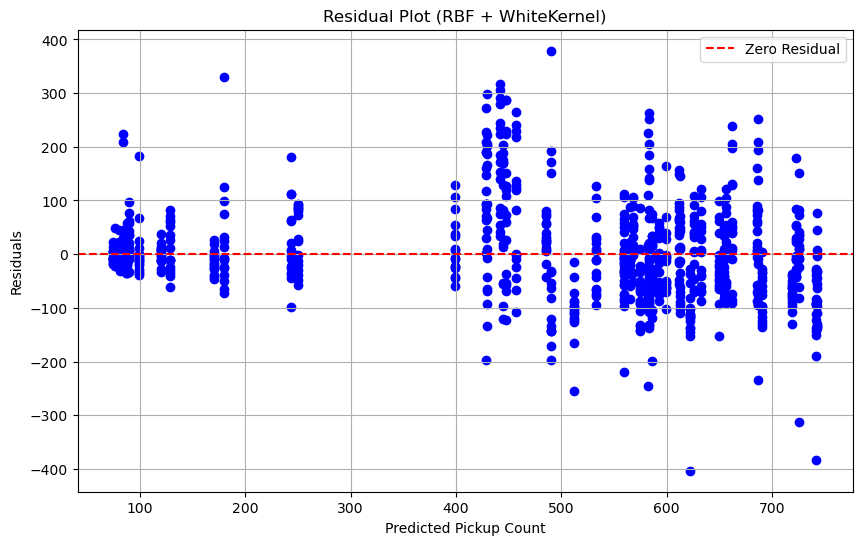

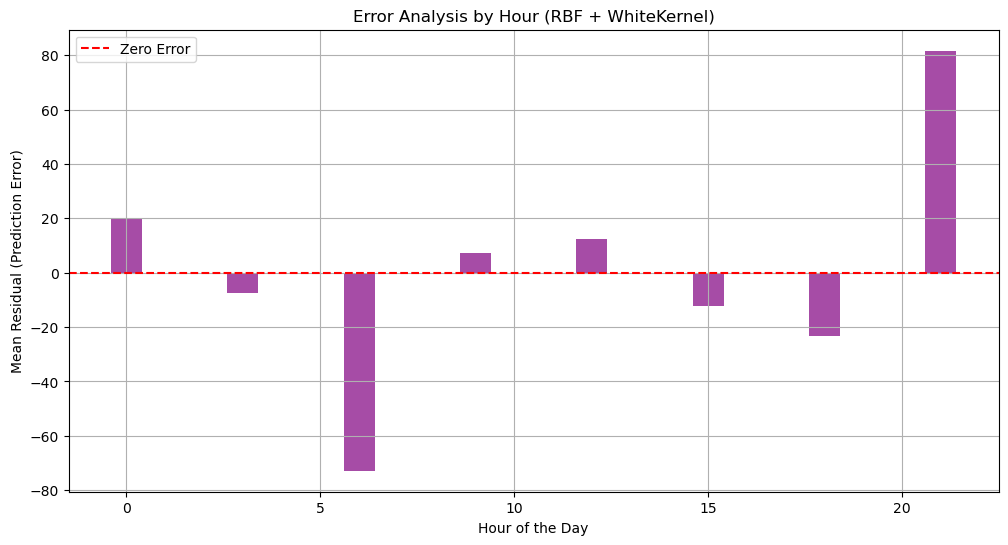

Training with kernel: RBF Only


/Users/willcalandra/anaconda3/envs/tsa/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Fit Complete
Learned Kernel: 305**2 * RBF(length_scale=0.276)
Kernel: RBF Only
Root Mean Squared Error: 89.193
R^2 Score: 0.853
MAPE: 16.036%


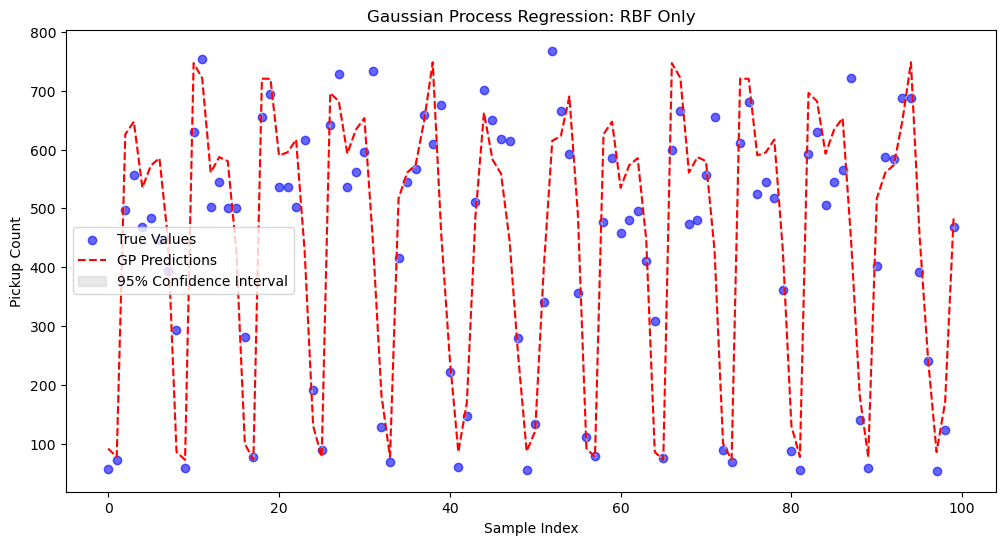

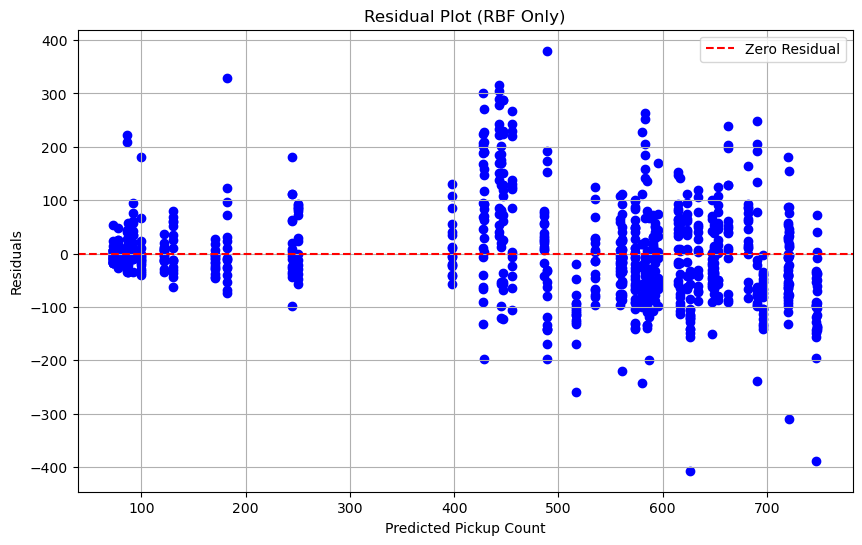

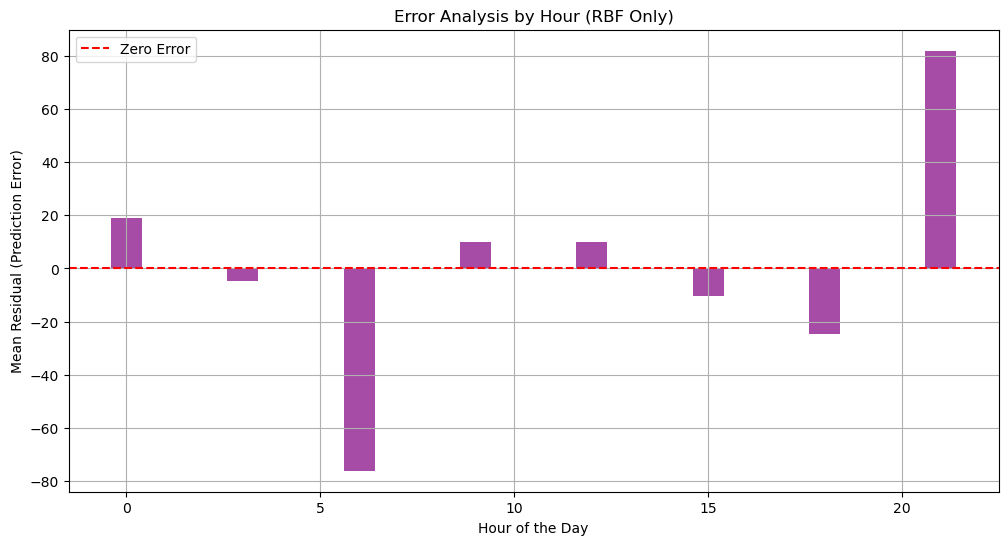

In [876]:
# Define a list of kernels to iterate through
kernels = [
    (
        "RBF + ExpSineSquared + WhiteKernel",
        C(30.0, (1e-1, 1e5)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
        + C(50.0, (1e-1, 1e5)) * ExpSineSquared(
            length_scale=1.0,
            periodicity=8,
            periodicity_bounds=(1e-2, 1e2),
            length_scale_bounds=(1e-2, 1e2)
        )
        + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-5, 1e5))
    ),
    (
        "RBF + WhiteKernel",
        C(30.0, (1e-1, 1e5)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
        + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-5, 1e5))
    ),
    (
        "RBF Only",
        C(30.0, (1e-1, 1e5)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
    ),
    # Add more kernel configurations here
]

# Iterate through each kernel configuration
for kernel_name, kernel in kernels:
    print(f"Training with kernel: {kernel_name}")
    
    # Instantiate and fit the Gaussian Process Regressor
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=50, alpha=1e-5)
    gp.fit(X_train, y_train)
    print("Fit Complete")
    print("Learned Kernel:", gp.kernel_)

    # Make predictions
    y_pred, sigma = gp.predict(X_test, return_std=True)

    # Compute metrics
    rmse = root_mean_squared_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    print(f"Kernel: {kernel_name}")
    print(f"Root Mean Squared Error: {rmse:.3f}")
    print(f"MAPE: {mape:.3%}")

    # Visualize predictions
    plt.figure(figsize=(12, 6))
    plt.scatter(range(len(y_test[:100])), y_test[:100], label="True Values", color="blue", alpha=0.6)
    plt.plot(range(len(y_pred[:100])), y_pred[:100], label="GP Predictions", color="red", linestyle="dashed")
    plt.fill_between(
        range(len(y_pred[:100])),
        y_pred[:100] - 1.96 * sigma[:100],
        y_pred[:100] + 1.96 * sigma[:100],
        color="lightgrey",
        alpha=0.5,
        label="95% Confidence Interval",
    )
    plt.xlabel("Sample Index")
    plt.ylabel("Pickup Count")
    plt.title(f"Gaussian Process Regression: {kernel_name}")
    plt.legend()
    plt.show()

    # Residual plot
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals, color='blue')
    plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
    plt.xlabel('Predicted Pickup Count')
    plt.ylabel('Residuals')
    plt.title(f'Residual Plot ({kernel_name})')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Error Analysis Over the Hour
    test['hour'] = test['pickup_time'].dt.hour
    error_by_hour = test.assign(residual=residuals).groupby('hour')['residual'].mean()
    
    plt.figure(figsize=(12, 6))
    plt.bar(error_by_hour.index, error_by_hour.values, color='purple', alpha=0.7)
    plt.axhline(0, color='red', linestyle='--', label='Zero Error')
    plt.xlabel("Hour of the Day")
    plt.ylabel("Mean Residual (Prediction Error)")
    plt.title(f"Error Analysis by Hour ({kernel_name})")
    plt.legend()
    plt.grid(True)
    plt.show()
